[View in Colaboratory](https://colab.research.google.com/github/BuzzWoll/Residential-Energy-Forecasting/blob/master/Submission_Version_Forecasting_electricity_demand.ipynb)

In [0]:
########################################################################################################
# The following code reproduces the work of:
# 
# Marino, D. L., Amarasinghe, K., & Manic, M. (2016, October). 
# Building energy load forecasting using deep neural networks. 
# In Industrial Electronics Society, IECON 2016-42nd Annual Conference of the IEEE (pp. 7046-7051). IEEE.
#
########################################################################################################

In [0]:
########################################################################################################
# Libraries
# Libraries are required such that we can concentrate on implementing the proposed architecture
########################################################################################################

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time
import random
from IPython.display import clear_output

from six.moves import range

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed, Dense, concatenate, Dropout, CuDNNLSTM, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import Sequence

In [0]:
########################################################################################################
# Data
########################################################################################################

# Downloading and loading the single residential power consumption dataset from UCI machine learning library
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen

resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip")
zipfile = ZipFile(StringIO(resp.read()))
df = pd.read_csv(zipfile.open('household_power_consumption.txt'),sep = ';',dtype={'Global_active_power':np.float64, 'Global_reactive_power':np.float64,
       'Voltage':np.float64, 'Global_intensity':np.float64, 'Sub_metering_1':np.float64, 'Sub_metering_2':np.float64,
       'Sub_metering_3':np.float64} ,na_values='?')

df['dateTime'] = pd.to_datetime(df['Date'] +' '+df['Time'], format = '%d/%m/%Y %H:%M:%S')
df.index = df['dateTime']

In [0]:
# Normalize data
def normalize(x):
  return (x-min(x))/(max(x)-min(x))

# Quickly pre-process and aggregate the data to a specific time level (e.g. hourly, minutely etc.)
def createFastAggregation(data,aggregation,normal=False):
  if(aggregation != '1T'):
    data = data.resample(aggregation).mean()
    data.reset_index(inplace=True)
  if(normal):
    data.Global_active_power = normalize(data.Global_active_power)
  data["day"] = data.dateTime.dt.day
  data["dayOfWeek"] = data.dateTime.dt.dayofweek
  data["hour"] = data.dateTime.dt.hour
  data["minute"] = data.dateTime.dt.minute
  data.index = data['dateTime']
  data = data.interpolate('index')
  return data

# Plot both curves for target and prediction values
def plot_results(predicted_data, true_data):
  fig = plt.figure(facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data, label='True Data')
  plt.plot(predicted_data, label='Prediction')
  plt.legend()
  plt.show()
  
# Plot results on training data and test data at once
def plot_train_test(pred_train, true_train,pred_test,true_test):
  fig = plt.figure(facecolor='white',figsize=(20,10))
  ax = fig.add_subplot(111)
  true_data = np.concatenate((true_train,true_test))
  predicted_data = np.concatenate((pred_train,pred_test))
  plt.axvline(x=pred_train.shape[0],color="red")
  ax.plot(true_data, label='True Data')
  plt.plot(predicted_data, label='Prediction')
  plt.legend()
  plt.show()

# Plot the RMSE error curve
def plot_error(error_seq):
  fig = plt.figure(facecolor='white')
  plt.plot(np.concatenate(([None],error_seq)),label='RMSE')
  plt.legend()
  plt.show()

In [0]:
########################################################################################################
# All functions needed for the simple LSTM forecast:
########################################################################################################

# Create datasets for the simple LSTM
def generateBasicSets(data,lag,split):
  # lag = how long should the distance between input and output be
  # To get the paper results, set this to 1 and 5
  data = data.as_matrix()
  sequence_length = lag+1
  
  result = np.asarray([data[index: index + sequence_length,] for index in range(data.shape[0] - sequence_length)])
  row = round(split * result.shape[0])
  
  # np.random.shuffle(train) # shuffling didn't really change anything
  # this is a weird way of getting lagged data, this would also work if want sequences as input, just replace :1 with :-1
  x_train = result[:int(row), :1] 
  y_train = result[:int(row), -1,0] 
  x_test = result[int(row):, :1] 
  y_test = result[int(row):, -1,0] 
  return x_train,x_test,y_train,y_test

# Define the simple LSTM
def build_model(layers):
    model = Sequential()

    model.add(LSTM(layers[1],input_shape=(None,layers[0]),return_sequences=True)) 
    model.add(Dropout(0.1))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(layers[3],activation = "linear"))

    model.compile(loss="mse", optimizer='adam') # As defined in paper
    
    return model

# Simple LSTM training
def simpleLSTM(data,lag,train_test_split,epochs,batch_size,neuronsL1,neuronsL2):
  x_train,x_test,y_train,y_test = generateBasicSets(data,lag,train_test_split)
  model = build_model([x_train.shape[2], neuronsL1, neuronsL2, 1])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  
  return x_train,x_test,y_train,y_test, model
  
#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

# Multi step forecast using the prediction as new input
def multistepForecast(data,model,forecast_length,batch_size):
  forecasts = list()
  X = data[np.newaxis,0,]
  for i in range(0,forecast_length):
    forecast = model.predict(X,batch_size=batch_size)
    forecasts.append(forecast)
    X = np.concatenate((forecasts[-1][0],data[i,0,1:])).reshape((1,1,data.shape[2]))
  return np.asarray(forecasts)

# Create multiple LSTM models and use the last forecast value to create an error metric for the specific timestamp
def deliverForecastValues(data,sequence_length,lags):# lags e.g. =[1,2,6,12,24,96,168]
  errors = list()
  for i in lags:
    _,x_test,_,y_test, model = simpleLSTM(data,i,0.75,5,sequence_length,50,50)
    res = list()
    print 'Starting prediction'
    for j in range(0,y_test.shape[0]-sequence_length):
      res.append((model.predict(x_test[j:j+sequence_length],batch_size=sequence_length)[-1]-y_test[j+sequence_length-1])**2)
    errors.append((i,np.sqrt(np.mean(res))))
    print 'finished model with lag: ',i
  return errors
    
    
    

In [0]:
########################################################################################################
# Generator Class for seq2seq LSTM
########################################################################################################

# taken from https://github.com/keras-team/keras-preprocessing/pull/7/commits/8514b364588c5d0961e90a9b7513d868ab8f80ff by Tanguy Urvoy, which is a current pull request for keras,
# i have modified it such that it takes lists as input and creates a generator for multiple inputs and outputs
# Most of the code is just modified from Keras implentation and the entire code is open source

# This is a definition for a generator which will automatically feed the sequence to sequence LSTM with batches
class multiAdvancedTimeseriesGenerator(Sequence):
    def __init__(self, data, targets, length=None,
                 sampling_rate=1,
                 stride=1,
                 start_index=0, end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=32,
                 hlength=None,
                 target_seq=False,
                 gap=None,
                 dtype=None):

        self.hlength = hlength
        if not isinstance(data,list):
          data = [data]
        if not isinstance(targets,list):
          targets = [targets]
        self.data = data
        self.targets = targets
        
        
        for i,_ in enumerate(data):
            self.data[i] = np.asarray(data[i])
        for j,_ in enumerate(targets):
            self.targets[j] = np.asarray(targets[j])
            if target_seq and len(self.targets[j].shape) < 2:
                self.targets[j] = np.expand_dims(self.targets[j], axis=-1) 
        
        
        if dtype is None:
            self.data_type = []
            self.targets_type = []
            for i in self.data:
              self.data_type.append(i.dtype)
            for j in self.targets:
              self.targets_type.append(j.dtype)
        else:
            self.data_type = dtype
            self.targets_type = dtype

        self.sampling_rate = sampling_rate
        self.batch_size = batch_size
        
        self.stride = stride
        if gap is None:
            gap = sampling_rate
        self.gap = gap

        sliding_win_size = (self.hlength - 1) * sampling_rate + gap
        self.start_index = start_index + sliding_win_size
        if end_index is None:
            end_index = data[0].shape[0]
        self.end_index = end_index
        self.reverse = reverse
        self.target_seq = target_seq
        self.len = (self.end_index -
                    self.start_index) // (self.batch_size * self.stride)


        self.perm = np.arange(self.start_index, self.end_index)
        if shuffle:
            np.random.shuffle(self.perm)
        
        
    def __len__(self):
        return self.len

    def _empty_batch(self, num_rows):
        sample_shapes = []
        for i in self.data:
          samples_shape = [num_rows,self.hlength] 
          samples_shape.extend(i.shape[1:])
          sample_shapes.append(samples_shape)
        target_shapes = []        
        for j in self.targets:
          if self.target_seq:
            targets_shape = [num_rows, self.hlength]
          else:
            targets_shape = [num_rows]
          targets_shape.extend(j.shape[1:])
          target_shapes.append(targets_shape)
        
        samples = [np.empty(sample_shapes[i],self.data_type[i]) for i,_ in enumerate(sample_shapes)]
        targets = [np.empty(target_shapes[i],self.targets_type[i]) for i,_ in enumerate(target_shapes)]
        
        return samples,targets

    def __getitem__(self, index):
        while index < 0:
            index += self.len
        assert index < self.len
        i = self.batch_size * self.stride * index
        assert i + self.batch_size * self.stride <= self.end_index
        rows = np.arange(i, i + self.batch_size * self.stride, self.stride)
        rows = self.perm[rows]

        samples,targets = self._empty_batch(len(rows))
        
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.gap - (self.hlength - 1) * self.sampling_rate,
                            rows[j] - self.gap + 1, self.sampling_rate)
            for i,_ in enumerate(samples):
              samples[i][j] = self.data[i][indices]
              if self.target_seq:
                  shifted_indices = range(rows[j] - (self.hlength - 1) * self.sampling_rate,
                                        rows[j] + 1, self.sampling_rate)
                  for i,_ in enumerate(targets):
                    targets[i][j] = self.targets[i][shifted_indices]

              else:
                for i,_ in enumerate(targets):
                  targets[i][j] = self.targets[i][rows[j]]
                
        if self.reverse:
          for i,_ in enumerate(samples):
            samples[i] = samples[i][:, ::-1, ...]
          return samples,targets
        
        return  samples,targets
      


In [0]:
########################################################################################################
# Additional Functions needed for the seq2seq LSTM 
########################################################################################################

# Generate input data for the sequence to sequence lstm
def generateSets(data,seq_len):
  y_0_in = data[:-(seq_len+1),0]
  f_1_in = data[1:-seq_len,1:]
  input_1 = np.concatenate((y_0_in,f_1_in),axis=1)
  y_1_out = data[1:,0]
  f_m_in = data[seq_len:,1:]
  y_m_out = data[seq_len:,0]
  return input_1,y_1_out,f_m_in,y_m_out

# Create a generator for the entire model
def generator_generator(data,sequence_length,start=0,end=None,batchSize=128):
  input_1,y_1_out,f_m_in,y_m_out = generateSets(data,sequence_length)
  return multiAdvancedTimeseriesGenerator([input_1,f_m_in],[y_1_out,y_m_out],hlength = sequence_length, sampling_rate=1, stride=1, start_index=start, end_index=end, shuffle=False, reverse=False, batch_size=batchSize,target_seq=True,gap=0)

# Create a generator only for the encoder part of the sequence to sequence LSTM
def enc_generator_generator(data,sequence_length,start=0,end=None,batchSize=128):
  input_1,y_1_out,f_m_in,y_m_out = generateSets(data,sequence_length)
  
  return multiAdvancedTimeseriesGenerator(input_1,y_1_out, hlength = sequence_length, sampling_rate=1, stride=1, start_index=start, end_index=end, shuffle=False, reverse=False, batch_size=batchSize,target_seq=True,gap=0)

# Function to get RMSE for every single timestep. 
# For the seq to seq model, we have both prediction and target sequences to calculate an error sequence.
def rmseCurve(model,generator,sequence_length):
  preds = model.predict_generator(generator)
  seqs = np.column_stack((preds[0][:,sequence_length-1,0],preds[1][:,:,0]))
  actuals = np.column_stack((generator[0][1][0][:,-1,0],generator[0][1][1][:,:,0]))
  
  for i in range(1,len(generator)):
    tmp = np.column_stack((generator[i][1][0][:,-1,0],generator[i][1][1][:,:,0]))
    actuals = np.concatenate((actuals,tmp))

  print 'Prediction and Actual Matrix sizes (reduced sizes depending on batch_size): ',seqs.shape,',', actuals.shape
  return np.sqrt(np.mean((seqs-actuals)**2,axis=0))


########################################################################################################
# Sequence to Sequence LSTM model definition
########################################################################################################

def createGeneratorEncDecModel(input_length,seq_len,no_params,units,dropout_rate = 0.1):
  
  # Encoder part:
  input_encoder = Input((seq_len,no_params+1),name='primary_input')
  encoder1,enc1_state_h,enc1_state_c = CuDNNLSTM(units = units[0],return_sequences=True,name='first_encoding_lstm',return_state=True)(input_encoder)
  drop_enc_1 = Dropout(rate=dropout_rate)(encoder1)
  encoder2,enc2_state_h,enc2_state_c = CuDNNLSTM(units = units[1],return_sequences=True,name='second_encoding_lstm',return_state=True)(drop_enc_1)
  drop_enc_2 = Dropout(rate=dropout_rate)(encoder2)
  
  encoder_out = TimeDistributed(Dense(1),name='enc_out_time_distributed')(drop_enc_2)
  
  # Decoder part:
  auxiliary_input = Input(shape=(seq_len,no_params),name='aux_input')

  decoder1 = CuDNNLSTM(units = units[2], return_sequences=True, name='first_decoding_lstm')(auxiliary_input,initial_state=[enc2_state_h,enc2_state_c])
  drop_dec_1 = Dropout(rate=dropout_rate)(decoder1)
  decoder2 = CuDNNLSTM(units = units[3], return_sequences=True, name='second_decoding_lstm')(drop_dec_1,initial_state=[enc2_state_h,enc2_state_c])
  drop_dec_2 = Dropout(rate=dropout_rate)(decoder2)
  decoder_out = TimeDistributed(Dense(1),name='dec_out_time_distributed')(drop_dec_2)
  enc_model = Model(inputs=input_encoder,outputs=encoder_out)
  model = Model(inputs=[input_encoder,auxiliary_input],outputs=[encoder_out,decoder_out])
  
  # Optimizer to use for training:
  customAdam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False,clipnorm=1.) # do not adjust decay for adam, as it should be learning decay by itself
  
  enc_model.compile(optimizer=customAdam,loss='mse')
  model.compile(optimizer=customAdam,loss='mse')
  
  return model,enc_model

# Define the training for the sequence to sequence model such that it can be reused
def seq2seqModel(data,sequence_length,batch_size,units=[20,20,20,20],enc_epochs=5,epochs=7):
  split = int(round(0.75 * data.shape[0]))
  train = np.asmatrix(data)[:split,:]
  test = np.asmatrix(data)[split:,:]
  
  #Create generators and model for training
  train_gen = generator_generator(train,sequence_length=sequence_length,batchSize=batch_size)
  test_gen = generator_generator(test,sequence_length=sequence_length,batchSize=batch_size)
  enc_gen_train = enc_generator_generator(train,sequence_length=sequence_length,batchSize=batch_size)
  enc_gen_test = enc_generator_generator(test,sequence_length=sequence_length,batchSize=batch_size)
  model, enc_model = createGeneratorEncDecModel(train.shape[0],sequence_length,no_params=data.shape[1]-1,units=units)
  
  # Train model
  enc_model.fit_generator(generator=enc_gen_train,epochs=enc_epochs,validation_data=enc_gen_test,validation_steps=(test.shape[0]/batch_size),steps_per_epoch=(train.shape[0]/batch_size))
  model.fit_generator(generator=train_gen,epochs=epochs,validation_data=test_gen,validation_steps=(test.shape[0]/batch_size),steps_per_epoch=(train.shape[0]/batch_size))
  return enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model

In [0]:
########################################################################################################
# The following code will basically be repeated 3 times for every time resolution.
# Starting here, is the actual execution of the code
########################################################################################################

In [0]:
########################################################################################################
# 1 Hour resolution
########################################################################################################

df_1h = createFastAggregation(df,'1H',normal = False)[['Global_active_power','day','dayOfWeek','hour']]
sequence_length = 168 # We will forecast data for 1 week with hourly resolution
measure_points = [1,12,24,96,168] # And consider different interesting measure points like after 1 day and 7days

In [72]:
# RMSE for different points in the entire sequence
errors = deliverForecastValues(df_1h,sequence_length,measure_points)
clear_output()
print(errors)

[(1, 0.55138856), (12, 0.7032634), (168, 0.69436955)]


In [73]:
# Train a sample network for graphs
x_train,x_test,y_train,y_test, model = simpleLSTM(df_1h,5,.75,10,sequence_length,50,50)

Train on 20749 samples, validate on 5188 samples
Epoch 1/10
20749/20749 [==============================] - 6s 270us/step - loss: 1.0542 - val_loss: 0.5690
Epoch 2/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.8413 - val_loss: 0.5291
Epoch 3/10
20749/20749 [==============================] - 2s 94us/step - loss: 0.8220 - val_loss: 0.5282
Epoch 4/10
20749/20749 [==============================] - 2s 93us/step - loss: 0.8155 - val_loss: 0.5472
Epoch 5/10
20749/20749 [==============================] - 2s 91us/step - loss: 0.8000 - val_loss: 0.5007
Epoch 6/10
20749/20749 [==============================] - 2s 91us/step - loss: 0.7881 - val_loss: 0.5055
Epoch 7/10
20749/20749 [==============================] - 2s 92us/step - loss: 0.7685 - val_loss: 0.4795
Epoch 8/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.7551 - val_loss: 0.5158
Epoch 9/10
20749/20749 [==============================] - 2s 90us/step - loss: 0.7468 - val_loss: 0.4696
Epoch

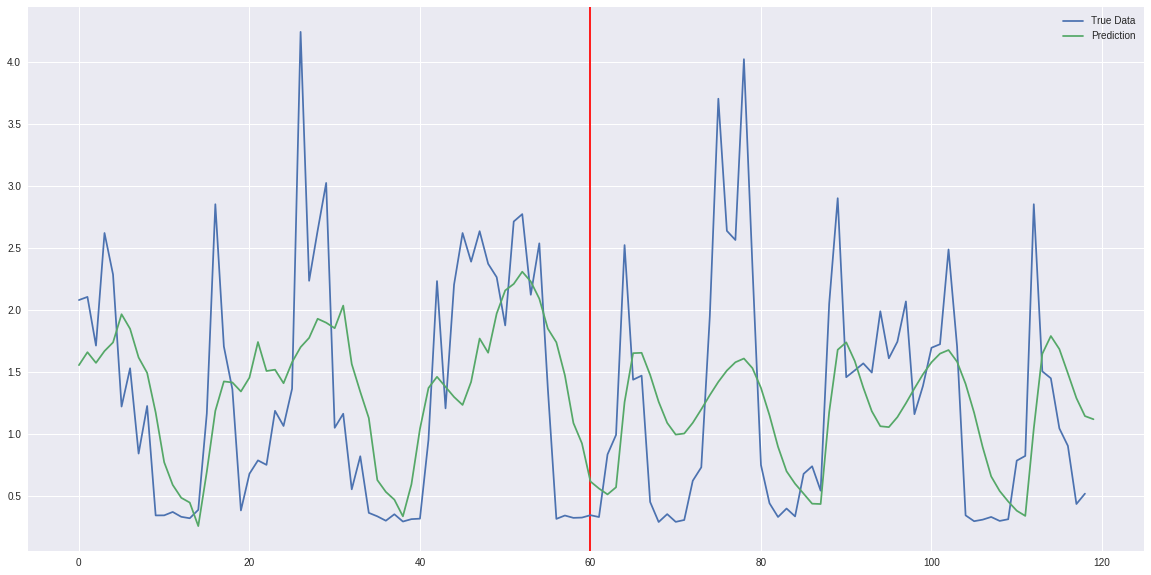

In [74]:
# Plot a specific section of the data and the corresponding predictions
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,batch_size)
#plot_results(forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [75]:
# Create a sequence to sequence model
batch_size = 64
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_1h,sequence_length,batch_size,[20,20,20,20],6,10)

Epoch 1/6
405/405 [==============================] - 31s 75ms/step - loss: 0.7383 - val_loss: 0.4020
Epoch 2/6
405/405 [==============================] - 22s 54ms/step - loss: 0.4489 - val_loss: 0.3011
Epoch 3/6
405/405 [==============================] - 22s 54ms/step - loss: 0.4043 - val_loss: 0.2877
Epoch 4/6
405/405 [==============================] - 22s 54ms/step - loss: 0.3896 - val_loss: 0.2890
Epoch 5/6
405/405 [==============================] - 22s 54ms/step - loss: 0.3791 - val_loss: 0.2846
Epoch 6/6
405/405 [==============================] - 22s 54ms/step - loss: 0.3695 - val_loss: 0.2764
Epoch 1/10
405/405 [==============================] - 60s 149ms/step - loss: 1.1487 - enc_out_time_distributed_loss: 0.3789 - dec_out_time_distributed_loss: 0.7698 - val_loss: 0.8271 - val_enc_out_time_distributed_loss: 0.2731 - val_dec_out_time_distributed_loss: 0.5540
Epoch 2/10
405/405 [==============================] - 42s 104ms/step - loss: 1.0781 - enc_out_time_distributed_loss: 0.3591

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [239]:
# Calculate the error curve
errorcurve = rmseCurve(model,test_gen,sequence_length)

(8256, 169) , (8256, 169)


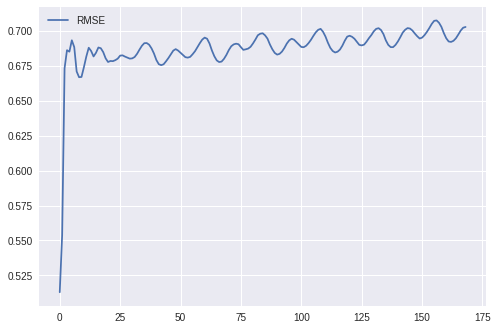

In [244]:
plot_error(errorcurve)

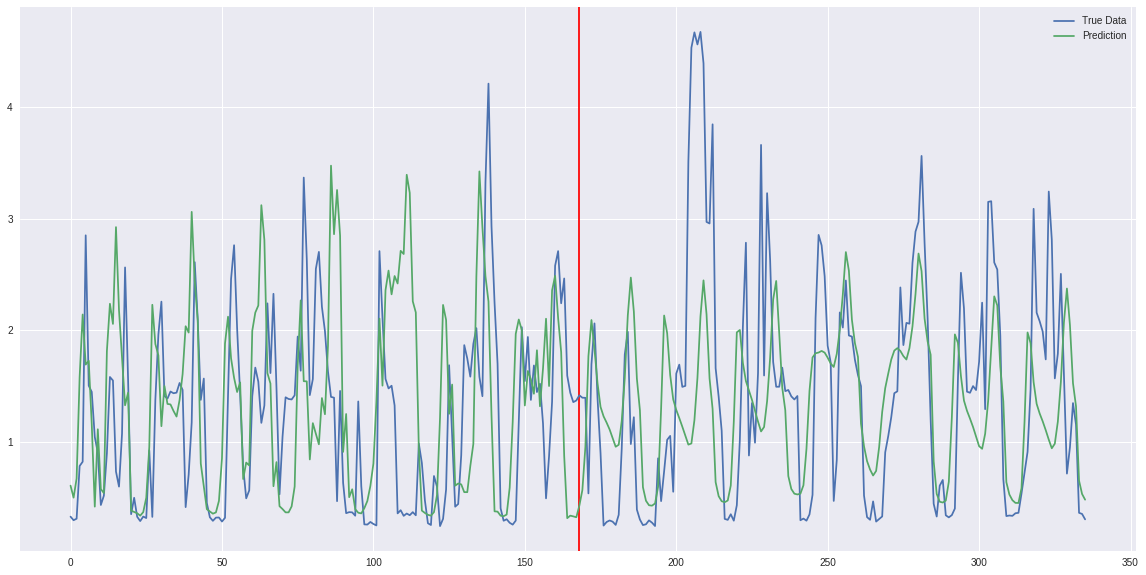

In [245]:
start = 180
plot_train_test(preds_enc[start],test[sequence_length+start-1:2*sequence_length+start-1,0],preds[1][start+sequence_length],test[2*sequence_length+start:3*sequence_length+start,0])

In [0]:
########################################################################################################
# 15Min
########################################################################################################
df_15min = createFastAggregation(df,'15T')[['Global_active_power','day','dayOfWeek','hour','minute']]
sequence_length = 96
measure_points = [1,4,24,48,96]

In [250]:
errors = deliverForecastValues(df_15min,sequence_length,measure_points)
clear_output()
print(errors)

[(1, 0.48072463), (4, 0.7264452), (24, 0.7920363), (48, 0.7984387), (96, 0.7839457)]


In [251]:
x_train,x_test,y_train,y_test, model = simpleLSTM(df_15min,5,.75,10,sequence_length,50,50)

Train on 83008 samples, validate on 20752 samples
Epoch 1/10
83008/83008 [==============================] - 21s 252us/step - loss: 0.8382 - val_loss: 0.5249
Epoch 2/10
83008/83008 [==============================] - 15s 181us/step - loss: 0.7646 - val_loss: 0.5311
Epoch 3/10
83008/83008 [==============================] - 15s 179us/step - loss: 0.7576 - val_loss: 0.5195
Epoch 4/10
83008/83008 [==============================] - 15s 184us/step - loss: 0.7503 - val_loss: 0.5169
Epoch 5/10
83008/83008 [==============================] - 15s 184us/step - loss: 0.7465 - val_loss: 0.5020
Epoch 6/10
83008/83008 [==============================] - 15s 182us/step - loss: 0.7403 - val_loss: 0.5050
Epoch 7/10
83008/83008 [==============================] - 16s 187us/step - loss: 0.7344 - val_loss: 0.4941
Epoch 8/10
83008/83008 [==============================] - 16s 187us/step - loss: 0.7312 - val_loss: 0.4900
Epoch 9/10
83008/83008 [==============================] - 15s 184us/step - loss: 0.7230 - val_

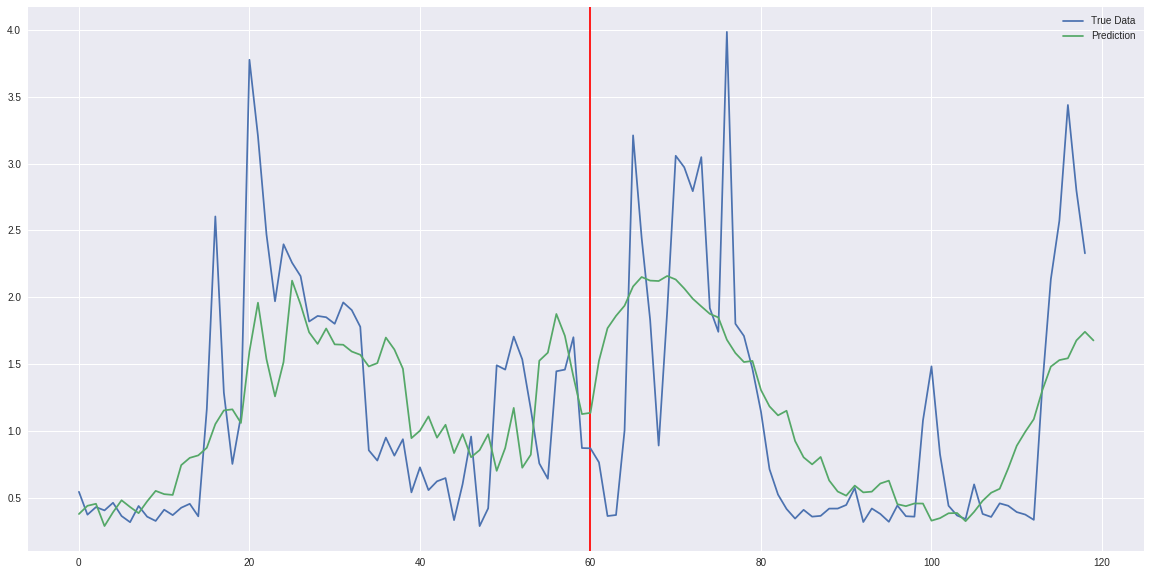

In [252]:
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,batch_size)

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [253]:
batch_size = 128
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_15min,sequence_length,batch_size,[20,20,20,20],6,10)

Epoch 1/6
810/810 [==============================] - 43s 54ms/step - loss: 0.5820 - val_loss: 0.2732
Epoch 2/6
810/810 [==============================] - 38s 47ms/step - loss: 0.3283 - val_loss: 0.2393
Epoch 3/6
810/810 [==============================] - 38s 47ms/step - loss: 0.3159 - val_loss: 0.2323
Epoch 4/6
810/810 [==============================] - 38s 46ms/step - loss: 0.3075 - val_loss: 0.2296
Epoch 5/6
810/810 [==============================] - 38s 47ms/step - loss: 0.2996 - val_loss: 0.2289
Epoch 6/6
810/810 [==============================] - 38s 46ms/step - loss: 0.3001 - val_loss: 0.2265
Epoch 1/10
810/810 [==============================] - 89s 109ms/step - loss: 1.2183 - enc_out_time_distributed_loss: 0.3034 - dec_out_time_distributed_loss: 0.9149 - val_loss: 0.9183 - val_enc_out_time_distributed_loss: 0.2598 - val_dec_out_time_distributed_loss: 0.6586
Epoch 2/10
810/810 [==============================] - 82s 102ms/step - loss: 1.1649 - enc_out_time_distributed_loss: 0.2928

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [255]:
errorcurve_15min = rmseCurve(model,test_gen,sequence_length)

(34304, 97) , (34304, 97)


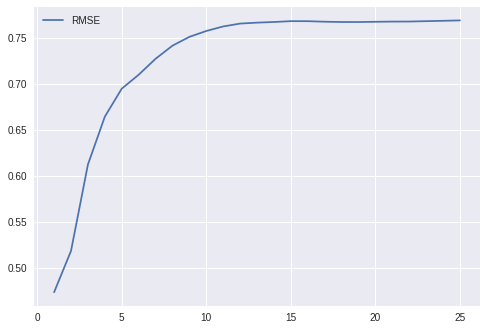

In [286]:
plot_error(errorcurve_15min[0:25])

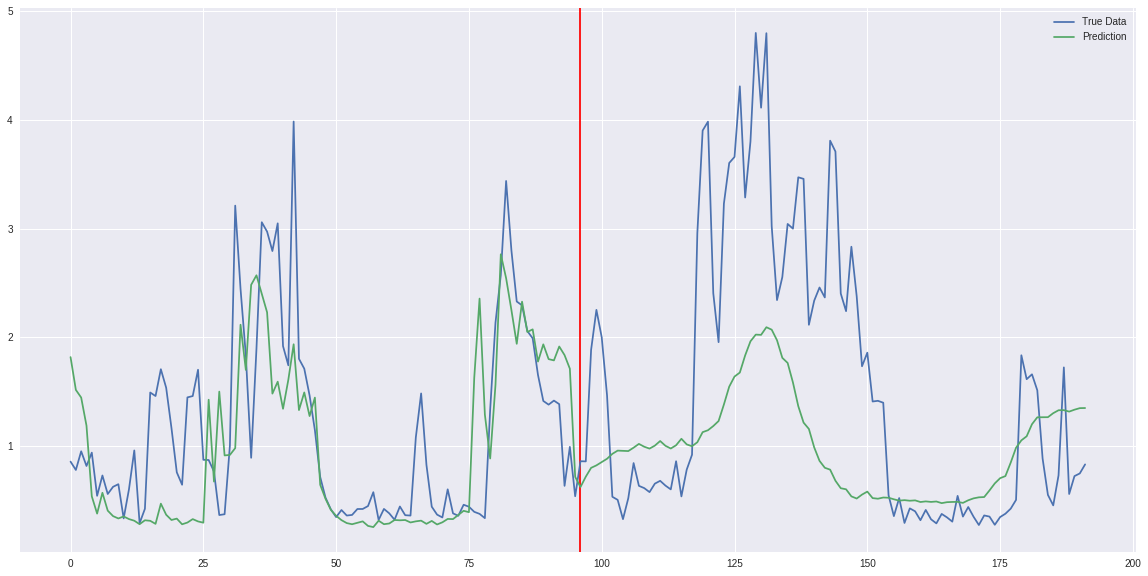

In [259]:
start = 180
plot_train_test(preds_enc[start],test[sequence_length+start-1:2*sequence_length+start-1,0],preds[1][start+sequence_length],test[2*sequence_length+start:3*sequence_length+start,0])

In [0]:
########################################################################################################
# 1Min
########################################################################################################
df_1min = createFastAggregation(df,'1T')[['Global_active_power','day','dayOfWeek','hour','minute']]
sequence_length = 120
measure_points = [1,5,30,60,120]

In [0]:
errors = deliverForecastValues(df_1min,sequence_length,measure_points)
clear_output()
print(errors)

In [0]:
x_train,x_test,y_train,y_test, model = simpleLSTM(df_1min,5,.75,10,sequence_length,50,50)

In [0]:
start = 240
stop = 300

predicted = predict_point_by_point(model, x_test[start:stop])        

forecasts = multistepForecast(x_test[stop:stop+(stop-start)],model,stop-start,batch_size)

plot_train_test(predicted[0:stop-start],y_test[start:stop],forecasts[:,0,0],y_test[stop:stop+(stop-start)-1])

In [0]:
batch_size = 128
enc_gen_train,enc_gen_test, train_gen,test_gen, train, test, enc_model, model = seq2seqModel(df_1min,sequence_length,batch_size,[20,20,20,20],6,10)

In [0]:
preds_enc = enc_model.predict_generator(enc_gen_test)
preds = model.predict_generator(test_gen)

In [0]:
errorcurve_1min = rmseCurve(model,test_gen,sequence_length)

In [0]:
plot_error(errorcurve_1min[0:25])

In [0]:
start = 180
plot_train_test(preds_enc[start],test[sequence_length+start-1:2*sequence_length+start-1,0],preds[1][start+sequence_length],test[2*sequence_length+start:3*sequence_length+start,0])